In [1]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
from astropy.io import fits
import tqdm

from matplotlib import rc
import matplotlib.pyplot as plt
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import cmasher as cm

import load_data as ld
import optimise as opt
import scatters as opt_sc
import init_latents as il
import kfold_cv as kf

In [2]:
# load the data
file_name = 'APOGEE_BOSS'
spectra_dir_path = '../spectra_more/'
file_path = '../data/training-set-APOGEE_BOSS-small.fits'
spectra_data, label_data = ld.load_data(spectra_dir_path, file_path, file_name)

ID = label_data['ids']
flux = spectra_data['fluxes']
flux_err = spectra_data['fluxes_err']
flux_ivar = spectra_data['fluxes_ivars']
label = label_data['labels']
label_err = label_data['labels_err']
label_ivar = label_data['labels_ivars']

../spectra_more/spectra_dataAPOGEE_BOSS.dat
File already exists. Loading spectra data


24it [00:01, 18.97it/s]

Loaded data successfully


# Split the data in train and validation sets

In [3]:
N = 1000

# train
train_ID = label_data['ids'][:N]
train_flux = spectra_data['fluxes'][:N]
train_flux_err = spectra_data['fluxes_err'][:N]
train_flux_ivar = spectra_data['fluxes_ivars'][:N]
train_label = label_data['labels'][:N]
train_label_err = label_data['labels_err'][:N]
train_label_ivar = label_data['labels_ivars'][:N]

# test
test_ID = label_data['ids'][N:]
test_flux = spectra_data['fluxes'][N:]
test_flux_err = spectra_data['fluxes_err'][N:]
test_flux_ivar = spectra_data['fluxes_ivars'][N:]
test_label = label_data['labels'][N:]
test_label_err = label_data['labels_err'][N:]
test_label_ivar = label_data['labels_ivars'][N:]

train_ID.shape, test_ID.shape

((1000,), (668,))

# train

In [4]:
P = 49
alphas, betas, zetas = il.initialise_alphas_betas_zetas(train_label, train_flux, P)
alphas.shape, betas.shape, zetas.shape

((12, 49), (4648, 49), (1000, 49))

In [5]:
niter = 5
alphas_iter = jnp.zeros((niter,) + alphas.shape)
betas_iter = jnp.zeros((niter,) + betas.shape)
zetas_iter = jnp.zeros((niter,) + zetas.shape)
diff_chi2_iter = jnp.zeros((niter))
chi2_iter = jnp.zeros((niter))

omega = 1.
for iter in tqdm.tqdm_notebook(range(niter)):
    alphas, betas, zetas, diff_chi2, chi2 = opt.run_agenda(alphas, betas, zetas, train_label, train_label_err, train_flux, train_flux_err, omega)
    alphas_iter = alphas_iter.at[iter].set(alphas)
    betas_iter = betas_iter.at[iter].set(betas)
    zetas_iter = zetas_iter.at[iter].set(zetas)
    diff_chi2_iter = diff_chi2_iter.at[iter].set(diff_chi2)
    chi2_iter = chi2_iter.at[iter].set(chi2)

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_85572/141839097.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iter in tqdm.tqdm_notebook(range(niter)):


  0%|          | 0/5 [00:00<?, ?it/s]

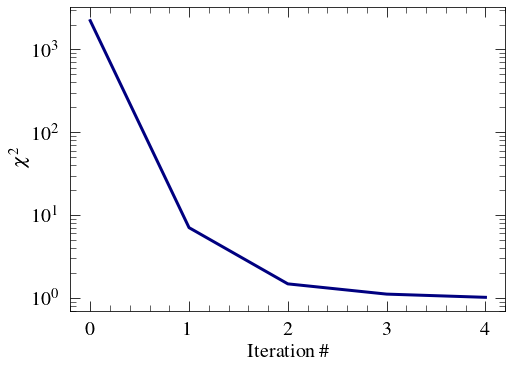

In [7]:
name = '_P25_omega1-train-small-APOGEEBOSS'
savepath = '../sav/'

np.save(savepath+'alphas_giants'+str(name), alphas_iter)
np.save(savepath+'betas_giants'+str(name), betas_iter)
np.save(savepath+'diff_chi2_giants'+str(name), diff_chi2_iter)
np.save(savepath+'chi2_giants'+str(name), chi2_iter)
np.save(savepath+'zetas_train_giants'+str(name), zetas_iter)

plt.figure(figsize=(7,5), constrained_layout=True)

plt.plot(chi2_iter, color='navy', lw=3)
plt.ylabel('$\chi^{2}$', fontsize=20)
plt.xlabel('Iteration $\#$', fontsize=20)
plt.yscale('log')
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

# plt.savefig('../plots/paper/chi2_giants'+str(name)+'.pdf',dpi=200, bbox_inches = 'tight')

# now optimise scatters

In [8]:
ln_noise_fluxes_init = jnp.full(train_flux.shape[1], -8.0)
l2_reg_strength = 1000

In [9]:
# run optimisation routine with noise in the flux
betas_updated, zetas_updated, ln_noise_fluxes_updated, nll_updated = opt_sc.run_agenda(alphas, betas, zetas, train_label, train_label_ivar, train_flux, train_flux_ivar,\
                                            ln_noise_fluxes_init, l2_reg_strength, omega)


In [10]:
name = '_P25_omega1-train-small-APOGEEBOSS'
savepath = '../sav/'

np.save(savepath+'alphas_giants-withscatters'+str(name), alphas)
np.save(savepath+'betas_giants-withscatters'+str(name), betas_updated)
np.save(savepath+'zetas_train_giants-withscatters'+str(name), zetas_updated)
np.save(savepath+'noise_fluxes_train_giants-withscatters'+str(name), jnp.exp(ln_noise_fluxes_updated))
np.save(savepath+'nll_train_giants-withscatters'+str(name),nll_updated)

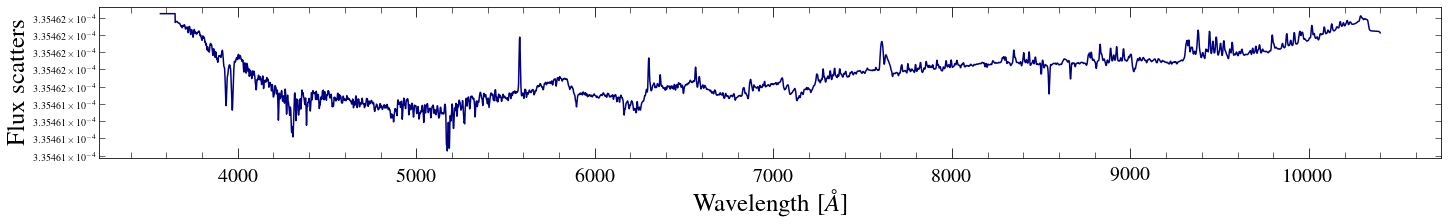

In [11]:

plt.figure(figsize=(20,3), constrained_layout=True, facecolor='white')

plt.plot(spectra_data['wl'], jnp.exp(ln_noise_fluxes_updated), color='navy')
plt.ylabel('Flux scatters', fontsize=25)
plt.xlabel('Wavelength [$\AA$]', fontsize=25)
plt.yscale('log')
# plt.ylim(0,0.02)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

# plt.savefig('../plots/paper/noise_fluxes_train_giants'+str(name)+'.pdf',dpi=200, bbox_inches = 'tight')

# see how train labels work

In [12]:
labels_train = zetas_updated @ alphas.T
spectra_train = zetas_updated @ betas_updated.T

In [13]:
train_snr = label_data['snr'][:N]
test_snr = label_data['snr'][N:]

test_snr.shape

(668,)

In [14]:
label_data['label_names']

['teff',
 'logg',
 'feh',
 'mgh',
 'alh',
 'ch',
 'nh',
 'sih',
 'nih',
 'mnh',
 'v_micro',
 'v_sini']

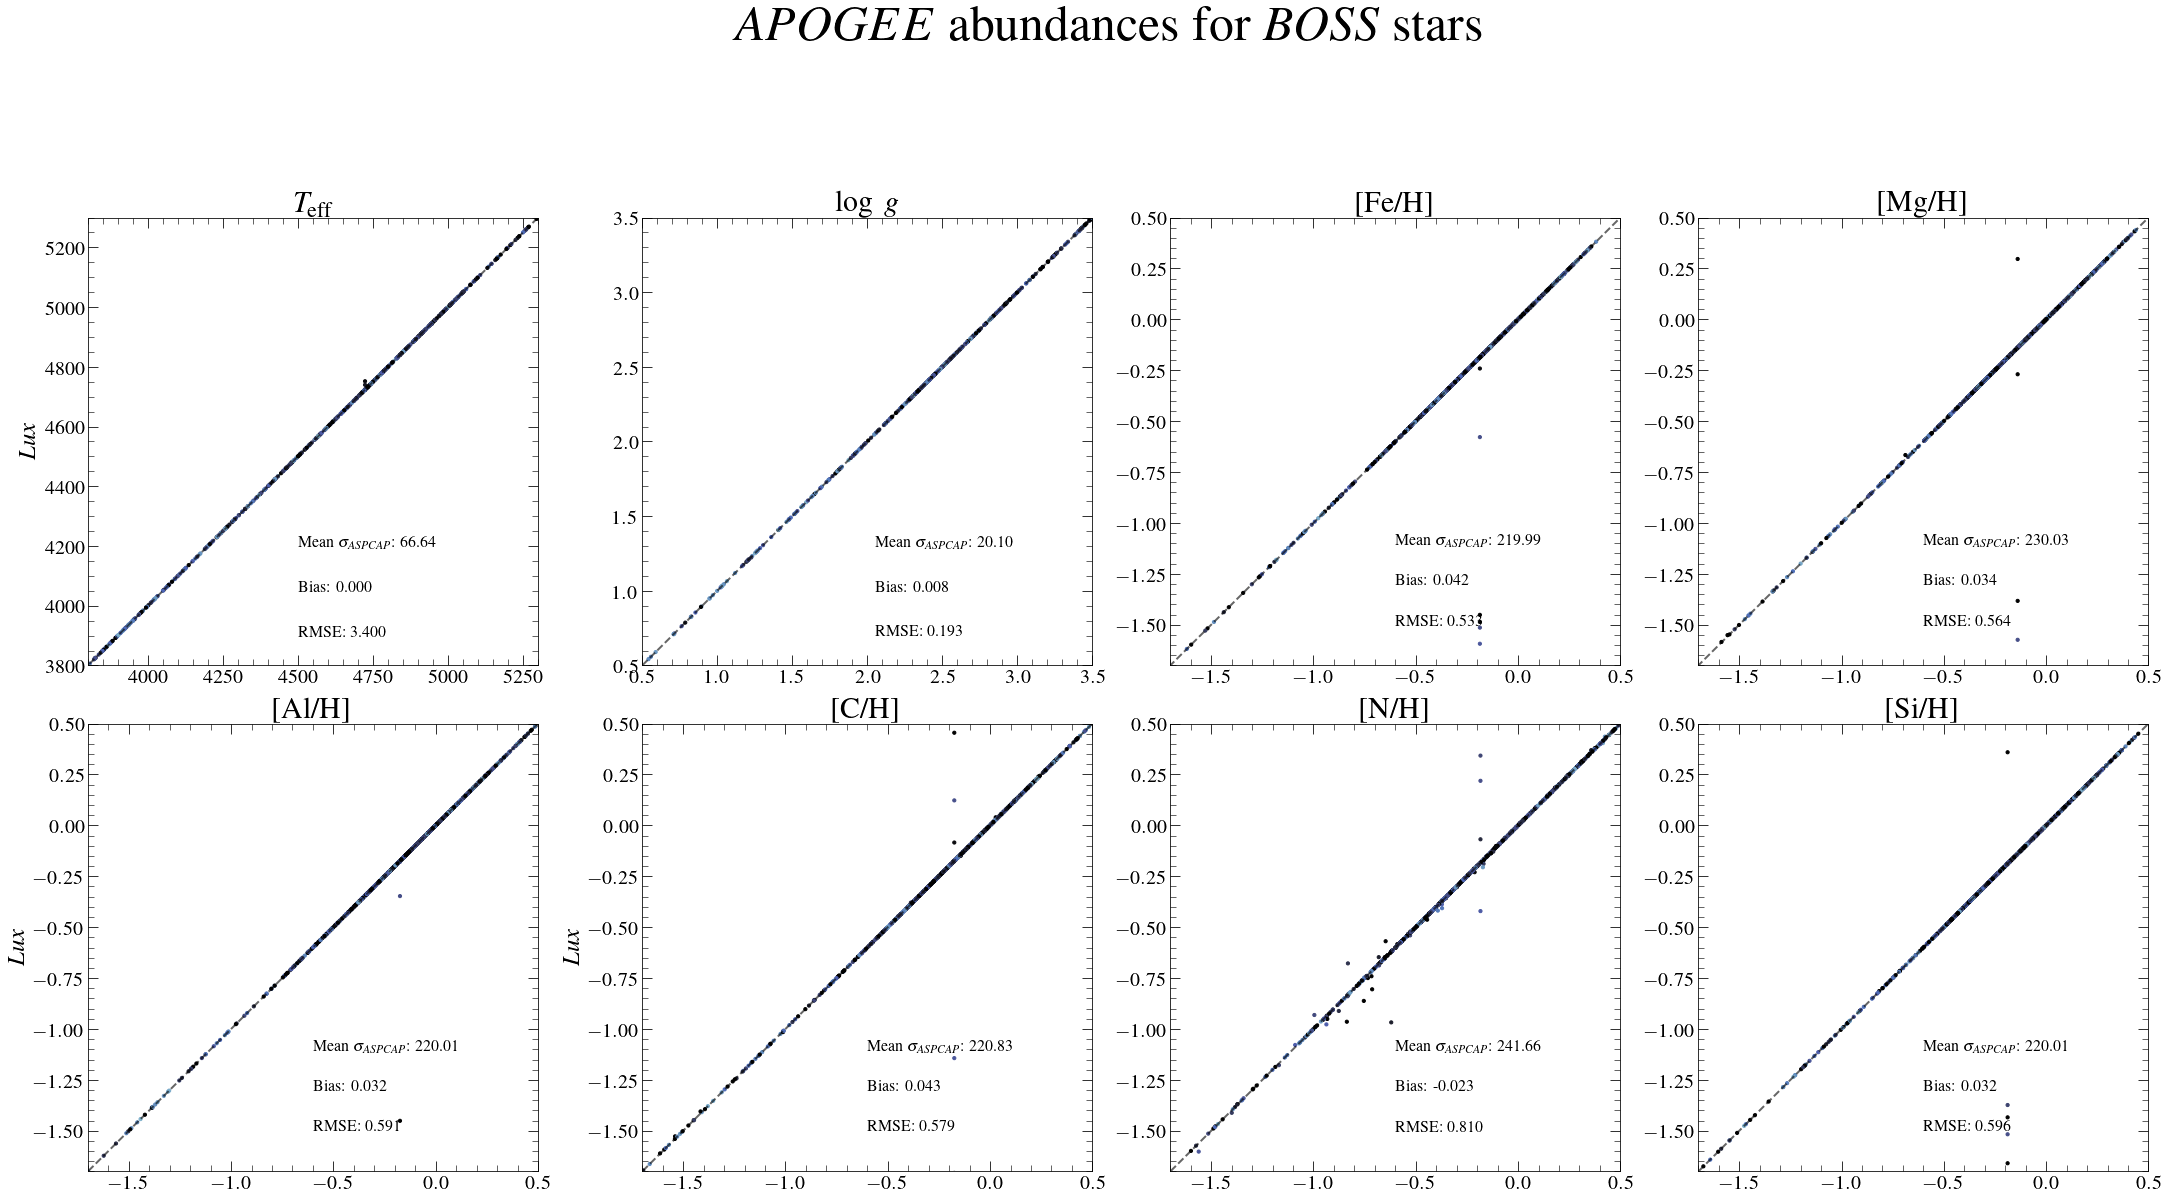

In [16]:
from matplotlib.colors import LinearSegmentedColormap

colors = ['indigo','rebeccapurple', 'blueviolet', 'mediumorchid','skyblue', 'lightblue', 'paleturquoise']
cmap1 = LinearSegmentedColormap.from_list("mycmap1", colors, N=6)
minval = 10
maxval = 60
bounds = np.linspace(minval, maxval, 7)

n = 10000
fig = plt.figure(figsize=(30,14), constrained_layout=True)
fig.suptitle('$APOGEE$ abundances for $BOSS$ stars',fontsize=50,x=0.51,y=1.18)

plt.subplot(2,4,1)
plt.title('$T_{\mathrm{eff}}$', fontsize=30)
plt.plot([3500,5500], [3500,5500], color='k',alpha=0.6, lw=2, ls='dashed')
plt.scatter(train_label[:n,0], labels_train[:,0], s=10, c=train_snr, cmap=cm.sapphire_r, vmin=10, vmax=60)
plt.text(4500,3900, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(train_label)*(jnp.nansum((train_label[:n,0]-labels_train[:,0])**2))))), fontsize=16)
plt.text(4500,4050, 'Bias: '+str("{:.3f}".format(jnp.median(train_label[:n,0]-labels_train[:,0]))), fontsize=16)
plt.text(4500,4200, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(train_label_err[:n,0]))), fontsize=16)
plt.xlim(3800,5300)
plt.ylim(3800,5300)
plt.ylabel(r'$Lux$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()


plt.subplot(2,4,2)
plt.title('$\log~g$', fontsize=30)
plt.plot([0,4],[0,4], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(2.05,0.7, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(train_label)*(jnp.nansum((train_label[:n,1]-labels_train[:,1])**2))))), fontsize=16)
plt.text(2.05,1.0, 'Bias: '+str("{:.3f}".format(jnp.mean(train_label[:n,1]-labels_train[:,1]))), fontsize=16)
plt.text(2.05,1.3, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(train_label_err[:n,1]))), fontsize=16)
plt.scatter(train_label[:n,1], labels_train[:,1], s=10, c=train_snr, cmap=cm.sapphire_r, vmin=10, vmax=60)
plt.xlim(0.5,3.5)
plt.ylim(0.5,3.5)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,4,3)
plt.title('[Fe/H]', fontsize=30)
plt.plot([-2,0.5], [-2,0.5], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(train_label)*(jnp.nansum((train_label[:n,2]-labels_train[:,2])**2))))), fontsize=16)
plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(train_label[:n,2]-labels_train[:,2]))), fontsize=16)
plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(train_label_err[:n,2]))), fontsize=16)
plt.scatter(train_label[:n,2], labels_train[:,2], s=10, c=train_snr, cmap=cm.sapphire_r, vmin=10, vmax=60)
plt.xlim(-1.7,0.5)
plt.ylim(-1.7,0.5)
# plt.ylabel(r'The Paton', fontsize=20)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,4,4)
plt.title('[Mg/H]', fontsize=30)
plt.plot([-2,0.5], [-2,0.5], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(train_label)*(jnp.nansum((train_label[:n,3]-labels_train[:,3])**2))))), fontsize=16)
plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(train_label[:n,3]-labels_train[:,3]))), fontsize=16)
plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(train_label_err[:n,3]))), fontsize=16)
plt.scatter(train_label[:n,3], labels_train[:,3], s=10, c=train_snr, cmap=cm.sapphire_r, vmin=10, vmax=60)
plt.xlim(-1.7,0.5)
plt.ylim(-1.7,0.5)
# plt.xlabel(r'ASPCAP', fontsize=20)
# plt.ylabel(r'The Paton', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,4,5)
plt.title('[Al/H]', fontsize=30)
plt.plot([-2,0.5], [-2,0.5], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(train_label)*(jnp.nansum((train_label[:n,4]-labels_train[:,4])**2))))), fontsize=16)
plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(train_label[:n,4]-labels_train[:,4]))), fontsize=16)
plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(train_label_err[:n,4]))), fontsize=16)
plt.scatter(train_label[:n,4], labels_train[:,4], s=10, c=train_snr, cmap=cm.sapphire_r, vmin=10, vmax=60)
plt.xlim(-1.7,0.5)
plt.ylim(-1.7,0.5)
plt.ylabel(r'$Lux$', fontsize=25)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,4,6)
plt.title('[C/H]', fontsize=30)
plt.plot([-2,0.5], [-2,0.5], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(train_label)*(jnp.nansum((train_label[:n,5]-labels_train[:,5])**2))))), fontsize=16)
plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(train_label[:n,5]-labels_train[:,5]))), fontsize=16)
plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(train_label_err[:n,5]))), fontsize=16)
plt.scatter(train_label[:n,5], labels_train[:,5], s=10, c=train_snr, cmap=cm.sapphire_r, vmin=10, vmax=60)
plt.xlim(-1.7,0.5)
plt.ylim(-1.7,0.5)
plt.ylabel(r'$Lux$', fontsize=25)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,4,7)
plt.title('[N/H]', fontsize=30)
plt.plot([-2,0.5], [-2,0.5], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(train_label)*(jnp.nansum((train_label[:n,6]-labels_train[:,6])**2))))), fontsize=16)
plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(train_label[:n,6]-labels_train[:,6]))), fontsize=16)
plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(train_label_err[:n,6]))), fontsize=16)
plt.scatter(train_label[:n,6], labels_train[:,6], s=10, c=train_snr, cmap=cm.sapphire_r, vmin=10, vmax=60)
plt.xlim(-1.7,0.5)
plt.ylim(-1.7,0.5)
# plt.ylabel(r'The Paton', fontsize=20)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,4,8)
plt.title('[Si/H]', fontsize=30)
plt.plot([-2,0.5], [-2,0.5], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(train_label)*(jnp.nansum((train_label[:n,7]-labels_train[:,7])**2))))), fontsize=16)
plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(train_label[:n,7]-labels_train[:,7]))), fontsize=16)
plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(train_label_err[:n,7]))), fontsize=16)
plt.scatter(train_label[:n,7], labels_train[:,7], s=10, c=train_snr, cmap=cm.sapphire_r, vmin=10, vmax=60)
plt.xlim(-1.7,0.5)
plt.ylim(-1.7,0.5)
# plt.ylabel(r'The Paton', fontsize=20)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()


# validation

In [17]:
# first using the fluxes
alphas_init_test, betas_init_test, zetas_init_test = il.initialise_alphas_betas_zetas(test_label, test_flux, P)

In [18]:
res_zetas_fromfluxes = opt_sc.get_zetas_test_using_fluxes(test_flux, test_flux_ivar, betas, zetas_init_test, ln_noise_fluxes_updated)
zetas_test_fromfluxes = res_zetas_fromfluxes.params['zetas']

In [19]:
labels_test_fromflux = zetas_test_fromfluxes @ alphas.T
spectra_test_fromflux = zetas_test_fromfluxes @ betas.T

In [20]:
savepath = '../sav/'
name = '_25_L2regstrength1000_omega1-APOGEEBOSS'
np.save(savepath+'zetas_test_fromflux_giants-withscatters'+str(name), zetas_test_fromfluxes)
np.save(savepath+'labels_test_fromflux_giants-withscatters'+str(name), labels_test_fromflux)
np.save(savepath+'spectra_test_fromflux_giants-withscatters'+str(name), spectra_test_fromflux)


In [21]:
train_snr = label_data['snr'][:N]
test_snr = label_data['snr'][N:]

test_snr.shape

(668,)

Text(0, 0.5, '[Mg/Fe]')

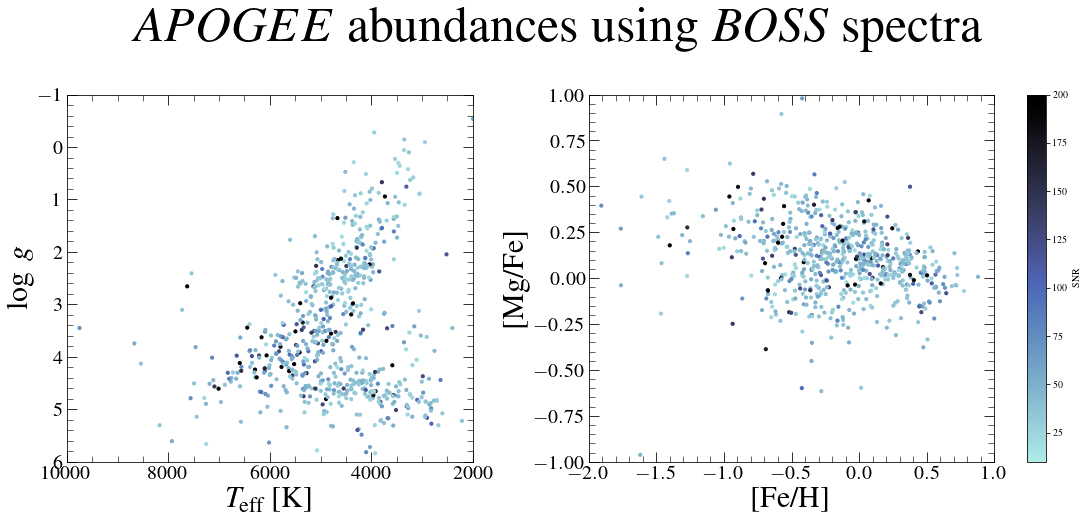

In [39]:
fig = plt.figure(figsize=(15,6), constrained_layout=True, facecolor='white')
fig.suptitle('$APOGEE$ abundances using $BOSS$ spectra',fontsize=50,x=0.51,y=1.18)

plt.subplot(1,2,1)
plt.scatter(labels_test_fromflux[:,0], labels_test_fromflux[:,1], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
# plt.colorbar()
plt.xlim(10000,2000)
plt.ylim(6, -1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel('$T_{\mathrm{eff}}$ [K]', fontsize=30)
plt.ylabel('$\log~g$', fontsize=30)

plt.subplot(1,2,2)
plt.scatter(labels_test_fromflux[:,2], labels_test_fromflux[:,3] - labels_test_fromflux[:,2], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
plt.colorbar(label='SNR')
plt.xlim(-2,1)
plt.ylim(-1,1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel('[Fe/H]', fontsize=30)
plt.ylabel('[Mg/Fe]', fontsize=30)

Text(0, 0.5, '[Mg/Fe]')

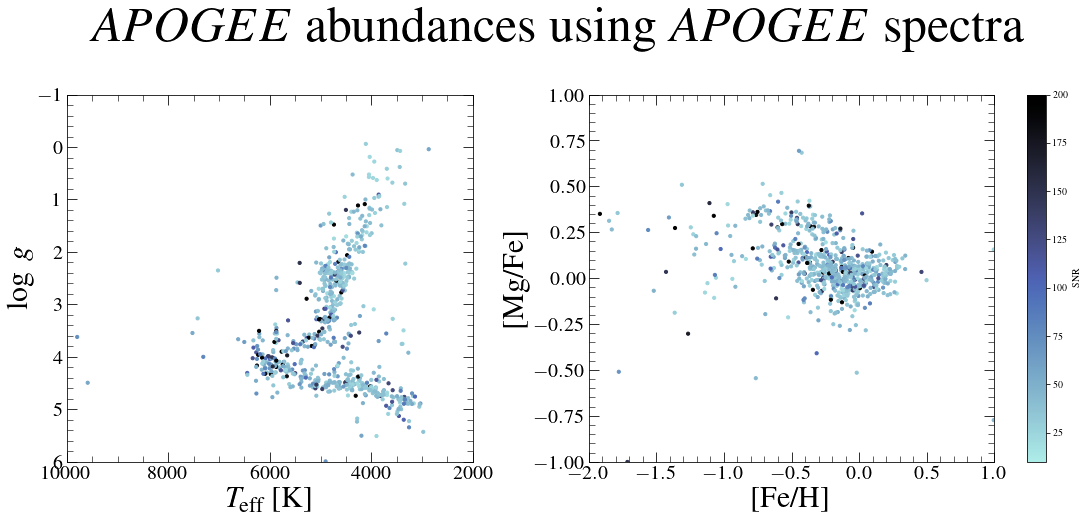

In [40]:
fig = plt.figure(figsize=(15,6), constrained_layout=True, facecolor='white')
fig.suptitle('$APOGEE$ abundances using $APOGEE$ spectra',fontsize=50,x=0.51,y=1.18)

plt.subplot(1,2,1)
plt.scatter(test_label[:,0], test_label[:,1], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
# plt.colorbar()
plt.xlim(10000,2000)
plt.ylim(6, -1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel('$T_{\mathrm{eff}}$ [K]', fontsize=30)
plt.ylabel('$\log~g$', fontsize=30)

plt.subplot(1,2,2)
plt.scatter(test_label[:,2], test_label[:,3] - test_label[:,2], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
plt.colorbar(label='SNR')
plt.xlim(-2,1)
plt.ylim(-1,1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel('[Fe/H]', fontsize=30)
plt.ylabel('[Mg/Fe]', fontsize=30)

Text(0, 0.5, '[Si/Fe]')

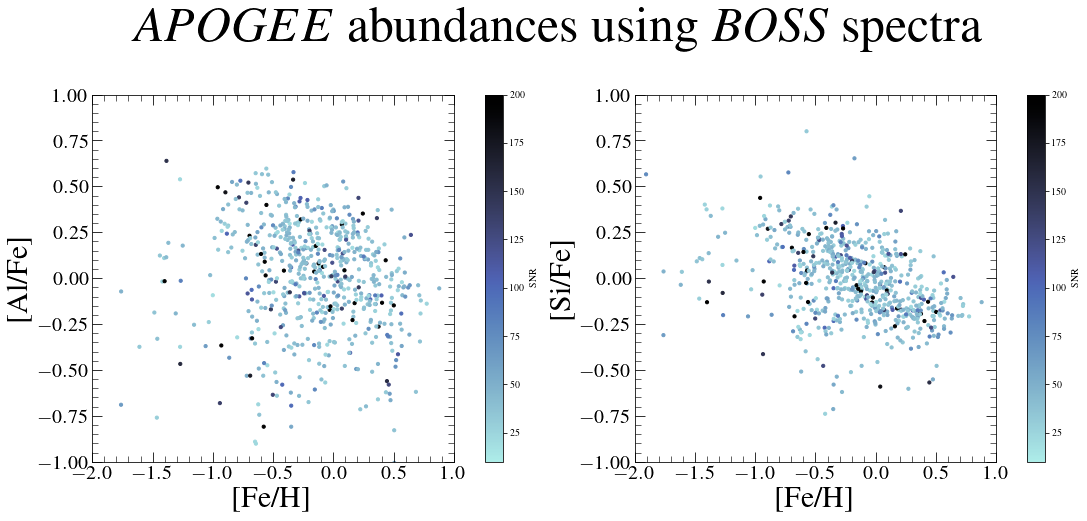

In [43]:
fig = plt.figure(figsize=(15,6), constrained_layout=True, facecolor='white')
fig.suptitle('$APOGEE$ abundances using $BOSS$ spectra',fontsize=50,x=0.51,y=1.18)

plt.subplot(1,2,1)
plt.scatter(labels_test_fromflux[:,2], labels_test_fromflux[:,4] - labels_test_fromflux[:,2], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
plt.colorbar(label='SNR')
plt.xlim(-2,1)
plt.ylim(-1,1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel('[Fe/H]', fontsize=30)
plt.ylabel('[Al/Fe]', fontsize=30)

plt.subplot(1,2,2)
plt.scatter(labels_test_fromflux[:,2], labels_test_fromflux[:,7] - labels_test_fromflux[:,2], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
plt.colorbar(label='SNR')
plt.xlim(-2,1)
plt.ylim(-1,1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel('[Fe/H]', fontsize=30)
plt.ylabel('[Si/Fe]', fontsize=30)

Text(0, 0.5, '[C/Fe]')

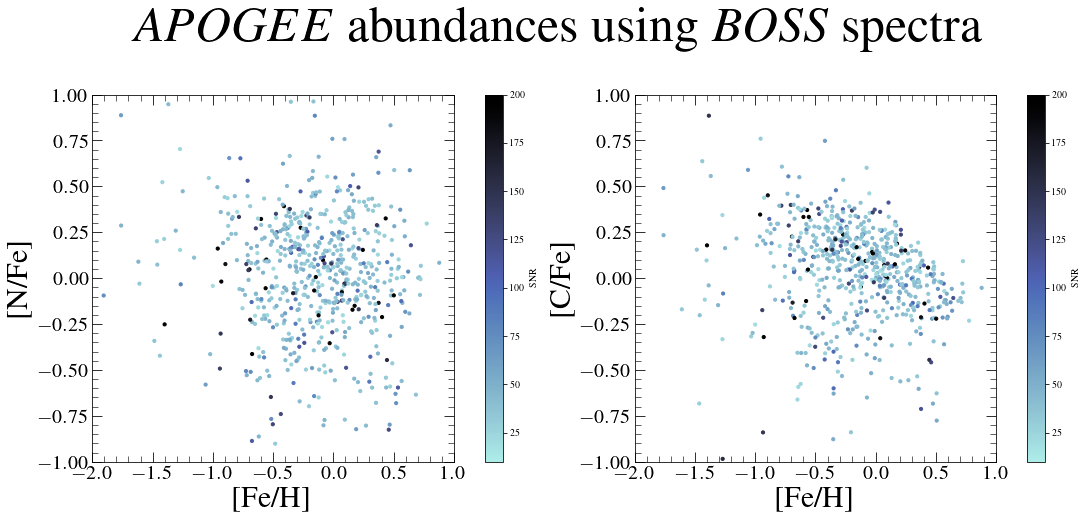

In [44]:
fig = plt.figure(figsize=(15,6), constrained_layout=True, facecolor='white')
fig.suptitle('$APOGEE$ abundances using $BOSS$ spectra',fontsize=50,x=0.51,y=1.18)

plt.subplot(1,2,1)
plt.scatter(labels_test_fromflux[:,2], labels_test_fromflux[:,6] - labels_test_fromflux[:,2], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
plt.colorbar(label='SNR')
plt.xlim(-2,1)
plt.ylim(-1,1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel('[Fe/H]', fontsize=30)
plt.ylabel('[N/Fe]', fontsize=30)

plt.subplot(1,2,2)
plt.scatter(labels_test_fromflux[:,2], labels_test_fromflux[:,5] - labels_test_fromflux[:,2], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
plt.colorbar(label='SNR')
plt.xlim(-2,1)
plt.ylim(-1,1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel('[Fe/H]', fontsize=30)
plt.ylabel('[C/Fe]', fontsize=30)

# Labels

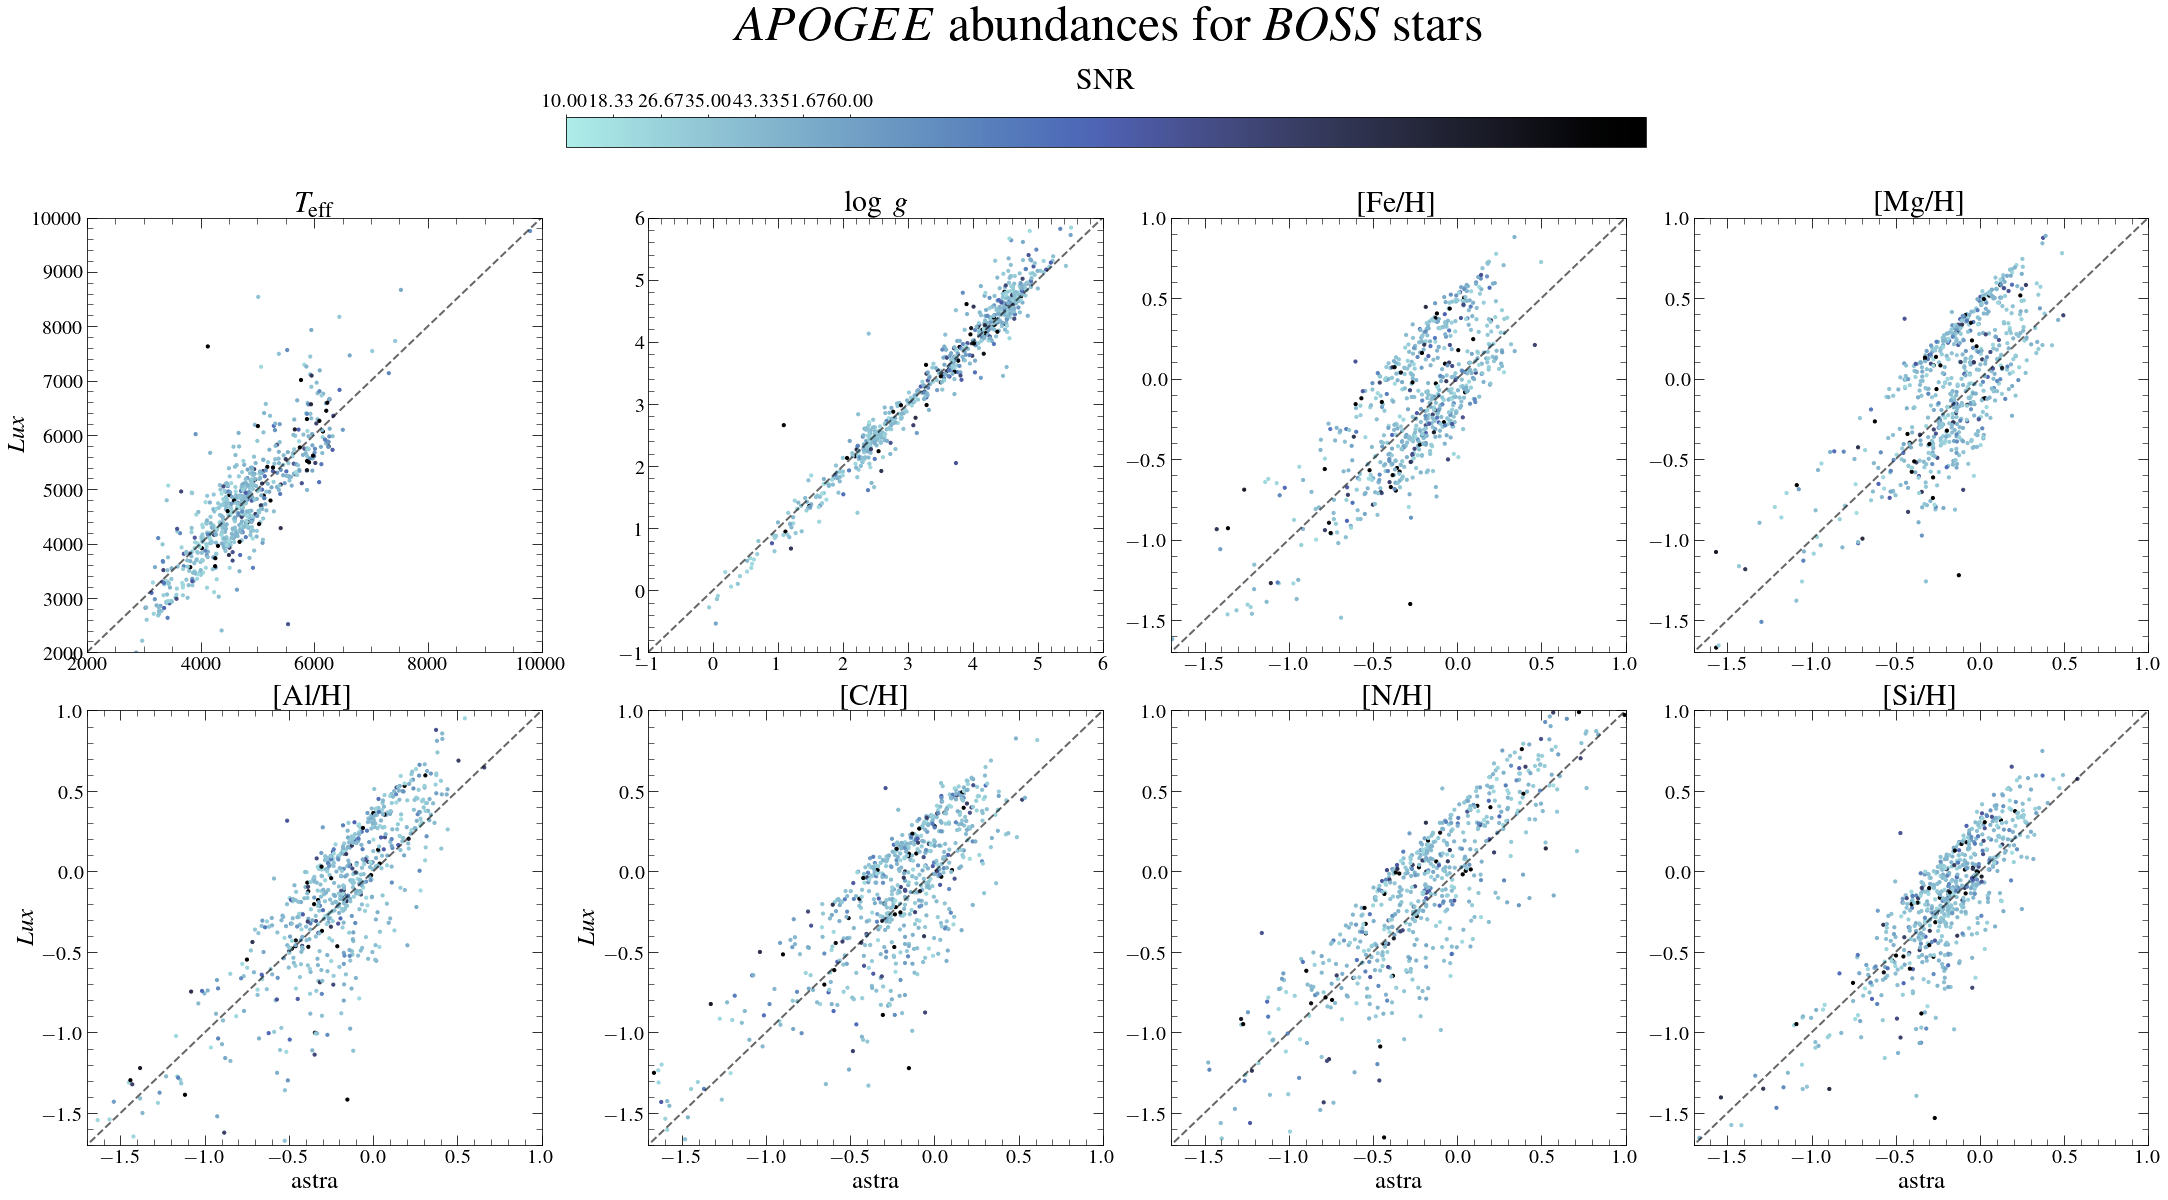

In [48]:
colors = ['indigo','rebeccapurple', 'blueviolet', 'mediumorchid','skyblue', 'lightblue', 'paleturquoise']
cmap1 = LinearSegmentedColormap.from_list("mycmap1", colors, N=6)
minval = 10
maxval = 60
bounds = np.linspace(minval, maxval, 7)

n = 1000
fig = plt.figure(figsize=(30,14), constrained_layout=True)
fig.suptitle('$APOGEE$ abundances for $BOSS$ stars',fontsize=50,x=0.51,y=1.18)

plt.subplot(2,4,1)
plt.title('$T_{\mathrm{eff}}$', fontsize=30)
plt.plot([2000,10000], [2000,10000], color='k',alpha=0.6, lw=2, ls='dashed')
color =  plt.scatter(test_label[:n,0], labels_test_fromflux[:,0], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
# plt.text(4500,3900, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,0]-labels_test_fromflux[:,0])**2))))), fontsize=16)
# plt.text(4500,4050, 'Bias: '+str("{:.3f}".format(jnp.median(test_label[:n,0]-labels_test_fromflux[:,0]))), fontsize=16)
# plt.text(4500,4200, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,0]))), fontsize=16)
plt.xlim(2000,10000)
plt.ylim(2000,10000)
plt.ylabel(r'$Lux$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()


plt.subplot(2,4,2)
plt.title('$\log~g$', fontsize=30)
plt.plot([-1,6],[-1,6], color='k',alpha=0.6, lw=2, ls='dashed')
# plt.text(2.05,0.7, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,1]-labels_test_fromflux[:,1])**2))))), fontsize=16)
# plt.text(2.05,1.0, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,1]-labels_test_fromflux[:,1]))), fontsize=16)
# plt.text(2.05,1.3, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,1]))), fontsize=16)
plt.scatter(test_label[:n,1], labels_test_fromflux[:,1], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
plt.xlim(-1,6)
plt.ylim(-1,6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,4,3)
plt.title('[Fe/H]', fontsize=30)
plt.plot([-2,1], [-2,1], color='k',alpha=0.6, lw=2, ls='dashed')
# plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,2]-labels_test_fromflux[:,2])**2))))), fontsize=16)
# plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,2]-labels_test_fromflux[:,2]))), fontsize=16)
# plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,2]))), fontsize=16)
plt.scatter(test_label[:n,2], labels_test_fromflux[:,2], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
plt.xlim(-1.7,1)
plt.ylim(-1.7,1)
# plt.ylabel(r'The Paton', fontsize=20)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,4,4)
plt.title('[Mg/H]', fontsize=30)
plt.plot([-2,1], [-2,1], color='k',alpha=0.6, lw=2, ls='dashed')
# plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,3]-labels_test_fromflux[:,3])**2))))), fontsize=16)
# plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,3]-labels_test_fromflux[:,3]))), fontsize=16)
# plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,3]))), fontsize=16)
plt.scatter(test_label[:n,3], labels_test_fromflux[:,3], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
plt.xlim(-1.7,1)
plt.ylim(-1.7,1)
# plt.xlabel(r'ASPCAP', fontsize=20)
# plt.ylabel(r'The Paton', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,4,5)
plt.title('[Al/H]', fontsize=30)
plt.plot([-2,1], [-2,1], color='k',alpha=0.6, lw=2, ls='dashed')
# plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,4]-labels_test_fromflux[:,4])**2))))), fontsize=16)
# plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,4]-labels_test_fromflux[:,4]))), fontsize=16)
# plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,4]))), fontsize=16)
plt.scatter(test_label[:n,4], labels_test_fromflux[:,4], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
plt.xlim(-1.7,1)
plt.ylim(-1.7,1)
plt.ylabel(r'$Lux$', fontsize=25)
plt.xlabel(r'astra', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,4,6)
plt.title('[C/H]', fontsize=30)
plt.plot([-2,1], [-2,1], color='k',alpha=0.6, lw=2, ls='dashed')
# plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,5]-labels_test_fromflux[:,5])**2))))), fontsize=16)
# plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,5]-labels_test_fromflux[:,5]))), fontsize=16)
# plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,5]))), fontsize=16)
plt.scatter(test_label[:n,5], labels_test_fromflux[:,5], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
plt.xlim(-1.7,1)
plt.ylim(-1.7,1)
plt.ylabel(r'$Lux$', fontsize=25)
plt.xlabel(r'astra', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,4,7)
plt.title('[N/H]', fontsize=30)
plt.plot([-2,1], [-2,1], color='k',alpha=0.6, lw=2, ls='dashed')
# plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,6]-labels_test_fromflux[:,6])**2))))), fontsize=16)
# plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,6]-labels_test_fromflux[:,6]))), fontsize=16)
# plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,6]))), fontsize=16)
plt.scatter(test_label[:n,6], labels_test_fromflux[:,6], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
plt.xlim(-1.7,1)
plt.ylim(-1.7,1)
# plt.ylabel(r'The Paton', fontsize=20)
plt.xlabel(r'astra', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,4,8)
plt.title('[Si/H]', fontsize=30)
plt.plot([-2,1], [-2,1], color='k',alpha=0.6, lw=2, ls='dashed')
# plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,7]-labels_test_fromflux[:,7])**2))))), fontsize=16)
# plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,7]-labels_test_fromflux[:,7]))), fontsize=16)
# plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,7]))), fontsize=16)
plt.scatter(test_label[:n,7], labels_test_fromflux[:,7], s=10, c=test_snr, cmap=cm.sapphire_r, vmin=10, vmax=200)
plt.xlim(-1.7,1)
plt.ylim(-1.7,1)
# plt.ylabel(r'The Paton', fontsize=20)
plt.xlabel(r'astra', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()



cbar_ax = fig.add_axes([0.26, 1.04, 0.5,0.03])
cbar = fig.colorbar(color, ticks=bounds, cax = cbar_ax,orientation='horizontal')
cbar.set_label(label=r'SNR',fontsize=30)
cbar.ax.tick_params(labelsize=20)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

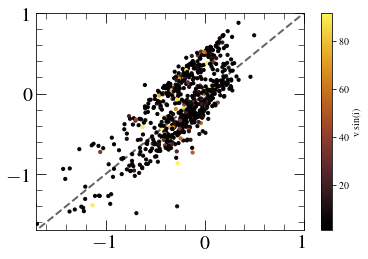

In [52]:
plt.plot([-2,1], [-2,1], color='k',alpha=0.6, lw=2, ls='dashed')
# plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,2]-labels_test_fromflux[:,2])**2))))), fontsize=16)
# plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,2]-labels_test_fromflux[:,2]))), fontsize=16)
# plt.text(-0.6,-1.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,2]))), fontsize=16)
plt.scatter(test_label[:n,2], labels_test_fromflux[:,2], s=10, c=labels_test_fromflux[:,-1], cmap=cm.amber)
plt.xlim(-1.7,1)
plt.ylim(-1.7,1)
plt.colorbar(label='v sin(i)')
# plt.ylabel(r'The Paton', fontsize=20)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

In [49]:
label_data['label_names']

['teff',
 'logg',
 'feh',
 'mgh',
 'alh',
 'ch',
 'nh',
 'sih',
 'nih',
 'mnh',
 'v_micro',
 'v_sini']